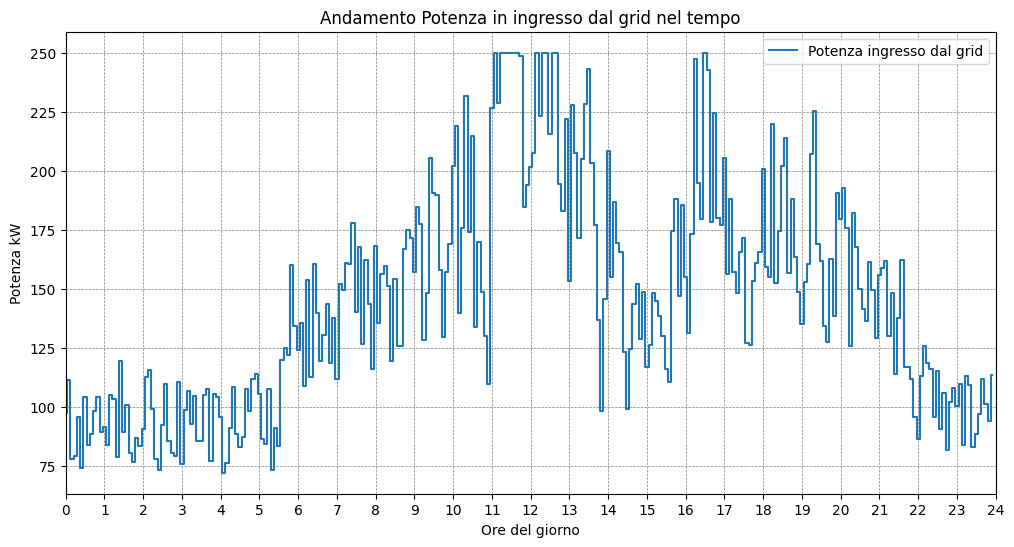

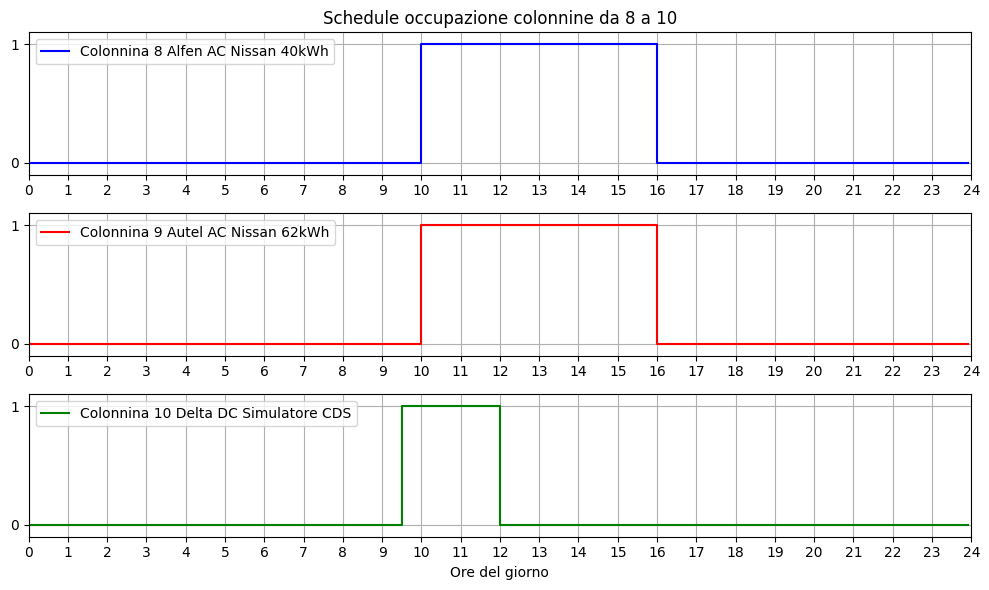

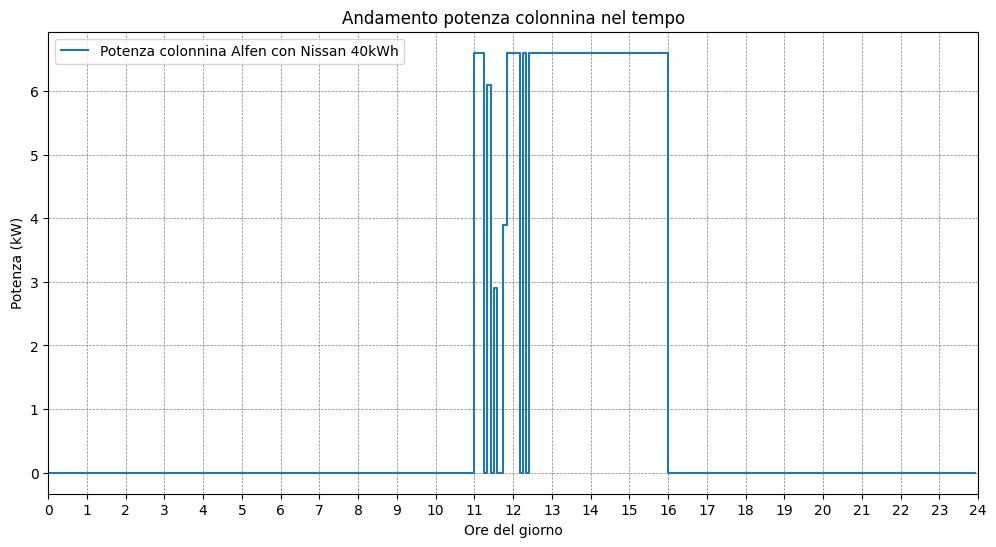

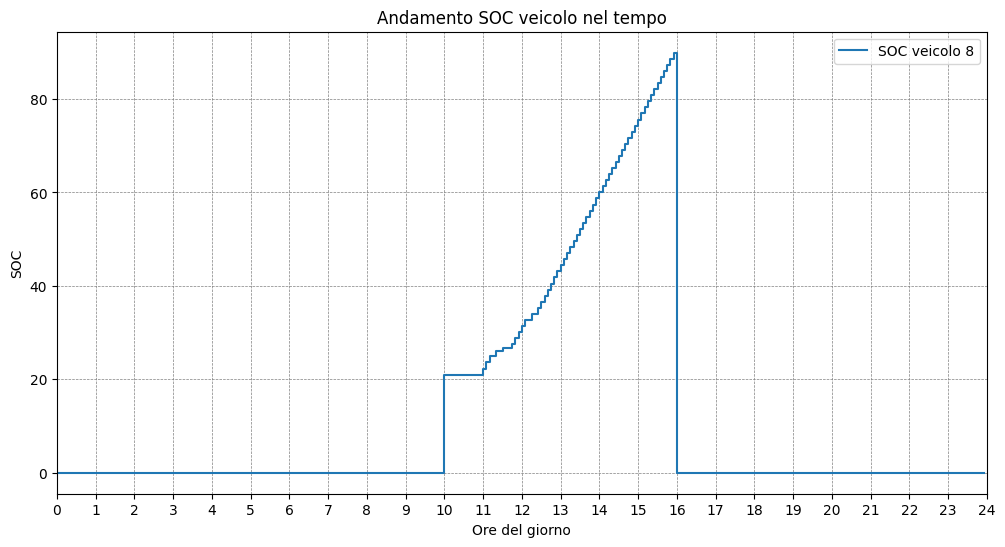

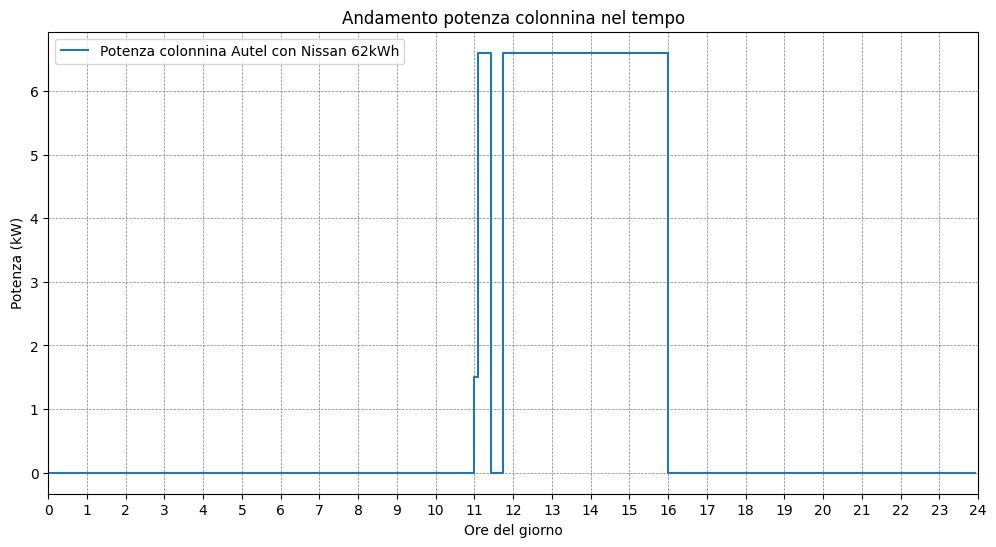

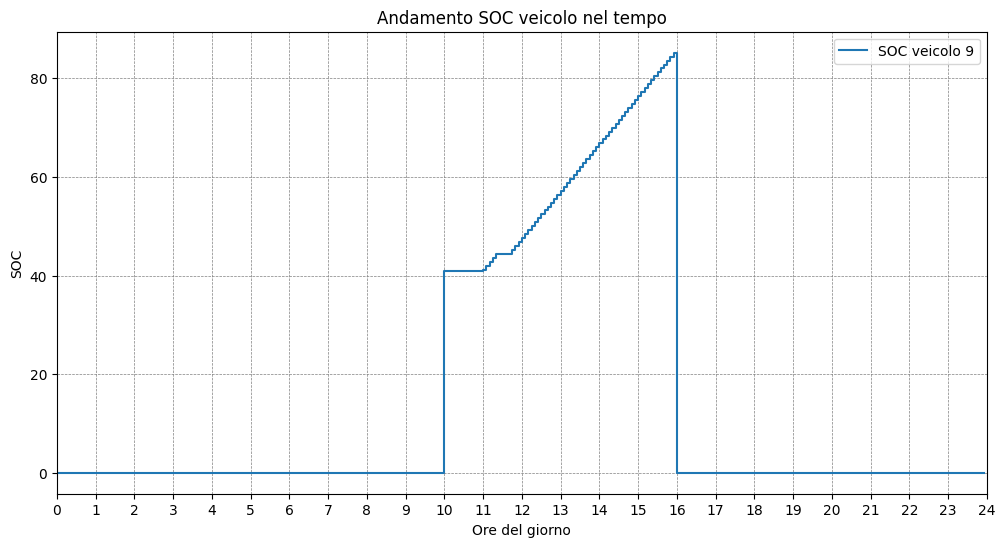

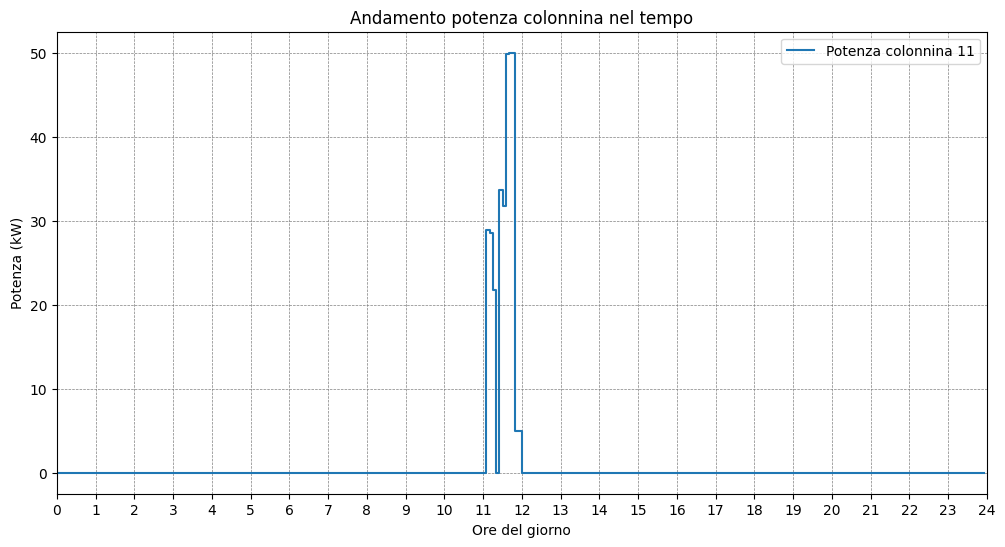

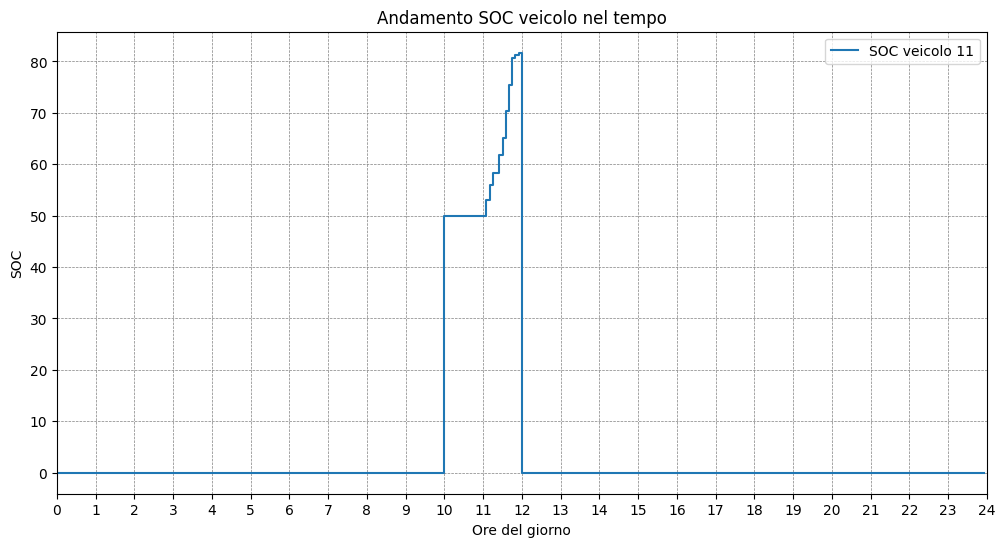

In [ ]:
#Grafici Output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
init_val={
    'timestamp':5,
    'numChargers' : 12,
    'v2g':False
}

timestamp=init_val['timestamp']
nWB=init_val['numChargers']
nTimeStamp=int(24*(60/timestamp))
Potenza_G2V=[0] * nWB
SOC_veicoli=[0] * nWB
P_grid_in=[]

df=pd.read_csv('Risultati.csv', header=None)
for i in range(12):
    Potenza_G2V[i]=df.iloc[:,i+3].tolist()
    SOC_veicoli[i]=df.iloc[:,i+15].tolist()

P_grid_in=df.iloc[:,27].tolist()

hours_in_day = np.array([t * timestamp / 60 for t in range(nTimeStamp)])  # converti in ore
# Definisci i limiti e i ticks per l'asse orizzontale (da 0 a 24 ore)
x_ticks = np.arange(0, 25, 1)  # Tick ad ogni ora

# # Grafico Potenza assorbita dal grid
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, P_grid_in, label=f"Potenza ingresso dal grid", where='mid')
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza kW")
plt.title("Andamento Potenza in ingresso dal grid nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()


#Stampa le schedule
def plot_schedule(schedules, num_stations=12):
    """
    Plot the schedules of multiple charging stations.

    Parameters:
    - schedules: numpy array with connection schedules
    - num_stations: number of charging stations (default: 12)
    """
    fig, axs = plt.subplots(3, 1, figsize=(10, 6))
    hours_in_day = np.array([t * timestamp / 60 for t in range(nTimeStamp)])
    etichetta=['Colonnina 8 Alfen AC Nissan 40kWh', 'Colonnina 9 Autel AC Nissan 62kWh', 'Colonnina 10 Delta DC Simulatore CDS']
    colore=['blue', 'red', 'green']

    for i in range(3):
        axs[i].step(hours_in_day, schedules[i+8], label=etichetta[i], color=colore[i], where='post')
        # plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
        # plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
        axs[i].set_xlim(0, 24)
        axs[i].set_xticks(np.arange(0, 25, 1))
        #axs[i].set_ylabel(f'Colonnina {i+8}')
        axs[i].set_ylim(-0.1, 1.1)
        axs[i].set_yticks([0, 1])
        axs[i].grid(True)
        axs[i].legend(loc='upper left')

    axs[0].set_title('Schedule occupazione colonnine da 8 a 10')
    axs[-1].set_xlabel('Ore del giorno')
    plt.tight_layout()
    plt.show()

def create_schedule(connection_times, disconnection_times, num_stations=init_val['numChargers'], intervals_per_day=int((60/init_val['timestamp'])*24)):
    """
    Crea la schedule di connessione/disconnessione per le colonnine.
    
    Parameters:
    - connection_times: lista di liste di tuple (ora, minuto) per la connessione
    - disconnection_times: lista di liste di tuple (ora, minuto) per la disconnessione
    - num_stations: numero di colonnine
    - intervals_per_day: numero di intervalli di 5 minuti in un giorno (288)
    
    Returns:
    - schedules: array numpy di shape (num_stations, intervals_per_day) con i flag di connessione
    """
    schedules = np.zeros((num_stations, intervals_per_day), dtype=int)
    
    for i in range(num_stations):
        for conn, disc in zip(connection_times[i], disconnection_times[i]):
            conn_index = time_to_index(*conn)
            disc_index = time_to_index(*disc)
            if conn_index < disc_index:
                schedules[i, conn_index:disc_index] = 1
            else:  # gestione di connessione durante la notte (es. dalle 23:00 alle 02:00)
                schedules[i, conn_index:] = 1
                schedules[i, :disc_index] = 1
    
    return schedules

def time_to_index(hour, minute):
    """Converte un orario (ora, minuto) in un indice del vettore (5 minuti)"""
    return (hour * 60 + minute) // init_val['timestamp']

#Legge il file schedule.csv e crea le liste connection times e disconnection times
connection_times = [None] * nWB
disconnection_times = [None] * nWB

df = pd.read_csv('schedule.csv', header=0)
Connessione1 = df['Connessione1'].tolist()
Disconnessione1 = df['Disconnessione1'].tolist()
Connessione2 = df['Connessione2'].tolist()
Disconnessione2 = df['Disconnessione2'].tolist()

for c in range(nWB):
    connection_times[c] = [(int(Connessione1[c].split(":")[0]), int(Connessione1[c].split(":")[1]))]
    if isinstance(Connessione2[c], str):
        connection_times[c].append((int(Connessione2[c].split(":")[0]), int(Connessione2[c].split(":")[1])))

for c in range(nWB):
    disconnection_times[c] = [(int(Disconnessione1[c].split(":")[0]), int(Disconnessione1[c].split(":")[1]))]
    if isinstance(Disconnessione2[c], str):
        disconnection_times[c].append((int(Disconnessione2[c].split(":")[0]), int(Disconnessione2[c].split(":")[1])))

schedule = create_schedule(connection_times, disconnection_times)
plot_schedule(schedule)


# # Grafico pG2V della stazione n
n=8 #Alfen con Nissan 40kWh
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, Potenza_G2V[n], label=f"Potenza colonnina Alfen con Nissan 40kWh", where='post')
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza (kW)")
plt.title("Andamento potenza colonnina nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()
# # Grafico SOC della stazione n
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, SOC_veicoli[n], label=f"SOC veicolo {n}", where='post')
plt.xlabel("Ore del giorno")
plt.ylabel("SOC")
plt.title("Andamento SOC veicolo nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

# # Grafico pG2V della stazione n
n=9  #Autel con Nissan 62kWh
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, Potenza_G2V[n], label=f"Potenza colonnina Autel con Nissan 62kWh", where='post')
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza (kW)")
plt.title("Andamento potenza colonnina nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()
# # Grafico SOC della stazione n
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, SOC_veicoli[n], label=f"SOC veicolo {n}", where='post')
plt.xlabel("Ore del giorno")
plt.ylabel("SOC")
plt.title("Andamento SOC veicolo nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

# # Grafico pG2V della stazione n
n=10
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, Potenza_G2V[n], label=f"Potenza colonnina {n}", where='post')
plt.xlabel("Ore del giorno")
plt.ylabel("Potenza (kW)")
plt.title("Andamento potenza colonnina nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()
# # Grafico SOC della stazione n
plt.figure(figsize=(12, 6))
plt.step(hours_in_day, SOC_veicoli[n], label=f"SOC veicolo {n}", where='post')
plt.xlabel("Ore del giorno")
plt.ylabel("SOC")
plt.title("Andamento SOC veicolo nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

#Stampa i grafici di tutte e 12 le colonnine
# for n in range(nWB):
#     plt.figure(figsize=(10, 4))
#     plt.step(hours_in_day, Potenza_G2V[n], label=f"Potenza colonnina {n}", where='post')
#     plt.xlabel("Ore del giorno")
#     plt.ylabel("Potenza (kW)")
#     plt.title("Andamento potenza colonnina nel tempo")
#     plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
#     plt.xlim(0, 24)  # Limita l'asse x tra 0 e 24 ore
#     plt.legend()
#     plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
#     plt.show()


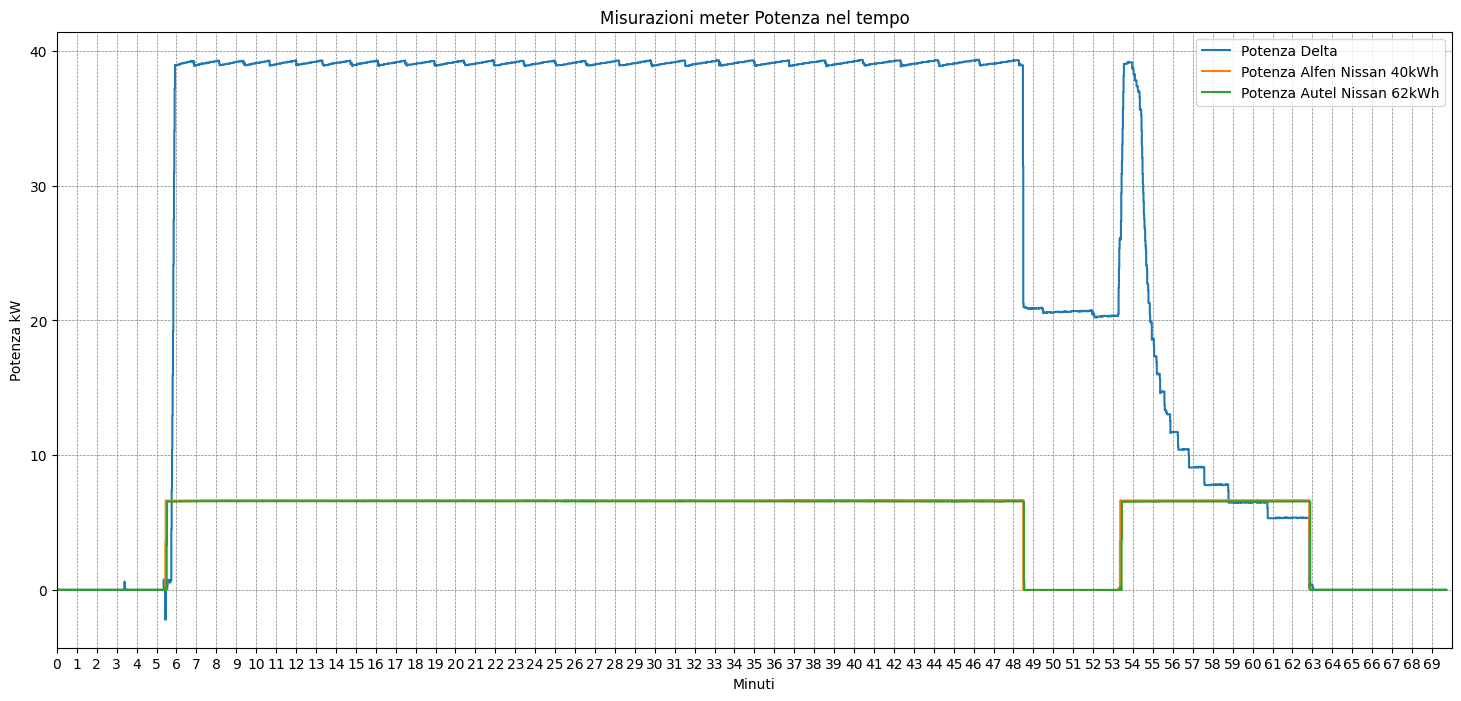

In [18]:
#Visualizzazione letture meter
import numpy as np
import matplotlib.pyplot as plt
import csv

granularity=1 #s. Sono i secondi di lettura dei meter.
Misure_Alfen=[]
Misure_Autel=[]
Misure_Totali=[]
with open('M_Alfen.csv', 'r') as file:
    lettore_csv = csv.reader(file)
    for riga in lettore_csv:
        Misure_Alfen.append(float(riga[13]))  #questa è solo la potenza della fase 1

with open('M_Autel.csv', 'r') as file:
    lettore_csv = csv.reader(file)
    for riga in lettore_csv:
        Misure_Autel.append(float(riga[13]))  #questa è solo la potenza della fase 1

with open('M_C.csv', 'r') as file:
    lettore_csv = csv.reader(file)
    for riga in lettore_csv:
        Misure_Totali.append(float(riga[13])+float(riga[14])+float(riga[15]))  #essendo trifase sommo la potenza delle 3 fasi

Misure_Alfen=np.array(Misure_Alfen)
Misure_Autel=np.array(Misure_Autel)
Misure_Totali=np.array(Misure_Totali)

Misure_Delta=(Misure_Totali-Misure_Autel)-Misure_Alfen

# # Grafico Potenza assorbita dalle colonnine
minuti = np.array([t * granularity / 60 for t in range(len(Misure_Delta))])
x_ticks = np.arange(0, round(granularity*len(Misure_Delta)/60), 1)

plt.figure(figsize=(18, 8))
plt.step(minuti, Misure_Delta/1000, label=f"Potenza Delta", where='mid')
plt.step(minuti, Misure_Alfen/1000, label=f"Potenza Alfen Nissan 40kWh", where='mid')
plt.step(minuti, Misure_Autel/1000, label=f"Potenza Autel Nissan 62kWh", where='mid')
plt.xlabel("Minuti")
plt.ylabel("Potenza kW")
plt.title("Misurazioni meter Potenza nel tempo")
plt.xticks(x_ticks)  # Mostra i ticks per ogni ora
plt.xlim(0, round(granularity*len(Misure_Delta)/60))  # Limita l'asse x tra 0 e 24 ore
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()


In [8]:
inizio=False

if not inizio:
    print("ok")


ok
